# Basic Regime Detection with Hidden-Regime

This notebook demonstrates the core functionality of the hidden-regime package:
- Loading financial data
- Generating observations 
- Training HMM model for regime detection
- Basic analysis and reporting

This is a minimal working example that demonstrates regime detection capabilities.

## Setup and Imports

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add the project root to the path if running from notebooks directory
if '../..' not in sys.path:
    sys.path.insert(0, '../..')

# Import hidden-regime components
from hidden_regime.data.financial import FinancialDataLoader
from hidden_regime.models.hmm import HiddenMarkovModel
from hidden_regime.observations.financial import FinancialObservationGenerator
from hidden_regime.analysis.financial import FinancialAnalysis
from hidden_regime.reports.markdown import MarkdownReportGenerator
from hidden_regime.config.data import FinancialDataConfig
from hidden_regime.config.model import HMMConfig
from hidden_regime.config.observation import FinancialObservationConfig
from hidden_regime.config.analysis import FinancialAnalysisConfig
from hidden_regime.config.report import ReportConfig

print("✅ Imports successful")

✅ Imports successful


## Configure Data Loading

Set up the configuration to load real market data. The system will automatically handle data loading and processing.

In [15]:
# Configuration
ticker = "NVDA"  # You can change this to any ticker: SPY, MSFT, TSLA, etc.
N_STATES = 4

print(f"📊 Configuring analysis for {ticker}...")

# Try to load real market data
try:
    data_loader = FinancialDataLoader(FinancialDataConfig(
        ticker=ticker,
        start_date="2023-01-01",
        end_date="2024-01-01"
    ))
    
    raw_data = data_loader.update()
    
    if not raw_data.empty:
        print(f"✅ Loaded {len(raw_data)} days of real market data for {ticker}")
        print(f"   Date range: {raw_data.index[0].date()} to {raw_data.index[-1].date()}")
    else:
        print(f"❌ No real data available for {ticker}")
        
except Exception as e:
    print(f"❌ Data loading failed: {e}")
    raw_data = pd.DataFrame()  # Will be handled below

# Display basic data info
if not raw_data.empty:
    print(f"\nData columns: {list(raw_data.columns)}")
    print(f"\nFirst few rows:")
    display(raw_data.head(3))

📊 Configuring analysis for NVDA...
✅ Loaded 249 days of real market data for NVDA
   Date range: 2023-01-04 to 2023-12-29

Data columns: ['open', 'high', 'low', 'close', 'volume', 'price', 'pct_change', 'log_return']

First few rows:


,open,high,low,close,volume,price,pct_change,log_return
Date,,,,,,,,
2023-01-04 00:00:00-05:00,14.553243,14.838972,14.227551,14.735070,431324000,14.588709,0.002609,0.002606
2023-01-05 00:00:00-05:00,14.477314,14.550245,14.134638,14.251528,389168000,14.353431,-0.016127,-0.016259
2023-01-06 00:00:00-05:00,14.460329,14.995823,14.020745,14.844966,405044000,14.580466,0.015817,0.015694


## Generate Observations

Create observations for the HMM model. We'll use log returns as the primary signal for regime detection.

In [3]:
if not raw_data.empty:
    print("🔍 Creating observations...")
    
    # Configure observation generation (using simple log returns)
    observation_config = FinancialObservationConfig(generators=['log_return'])
    observation_component = FinancialObservationGenerator(observation_config)
    
    # Generate observations
    observations = observation_component.update(raw_data)
    print(f"✅ Generated {len(observations)} observations")
    
    # Display observation statistics
    print(f"\nObservation statistics:")
    display(observations.describe())
else:
    print("❌ Cannot create observations without data")

🔍 Creating observations...
✅ Generated 249 observations

Observation statistics:


,open,high,low,close,volume,price,pct_change,log_return
count,249.000000,249.000000,249.000000,249.000000,2.490000e+02,1.000000,1.000000,249.000000
mean,36.577455,37.186851,35.989894,36.633867,4.738477e+08,1.203644,-0.261151,0.004917
std,10.779297,10.844001,10.584696,10.680865,1.616625e+08,NaN,NaN,0.026237
min,14.460329,14.550245,14.020745,14.251528,1.982090e+08,1.203644,-0.261151,-0.048200
25%,26.816209,27.161938,26.412522,26.935114,3.785270e+08,1.203644,-0.261151,-0.009607
50%,41.652014,42.510943,40.955863,41.886314,4.344360e+08,1.203644,-0.261151,0.003943
75%,45.757258,46.197769,44.983487,45.637337,5.179690e+08,1.203644,-0.261151,0.016270
max,50.182284,50.518221,49.387235,50.379303,1.543911e+09,1.203644,-0.261151,0.230818


<Axes: xlabel='Date'>

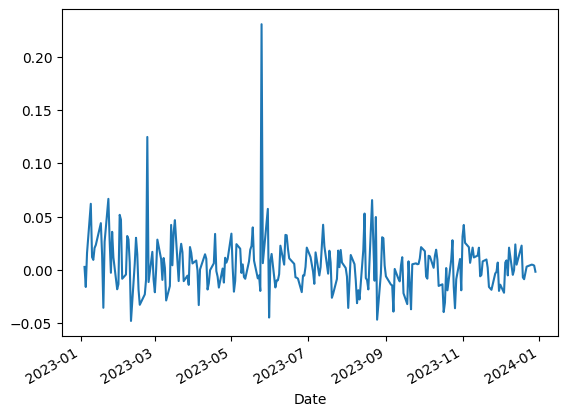

In [4]:
observations.log_return.plot()

## Train HMM Model

Train a Hidden Markov Model to detect market regimes. We'll use 3 states representing different market conditions.

In [13]:
if not raw_data.empty:
    print("🤖 Training HMM model...")
    
    # Configure HMM with 3 states (bear, sideways, bull)
    model_config = HMMConfig(n_states=N_STATES, random_seed=42, initialization_method='kmeans')
    hmm_model = HiddenMarkovModel(model_config)
    
    # Train model and get predictions
    model_output = hmm_model.update(observations)
    print(f"✅ Model trained successfully")
    print(f"📊 Generated {len(model_output)} regime predictions")
    
    # Analyze current regime
    current_regime = model_output['predicted_state'].iloc[-1]
    confidence = model_output.get('confidence', pd.Series([0.0])).iloc[-1]
    if pd.isna(confidence):
        confidence = 0.0
    
    regime_names = ['Bear Market', 'Sideways Market', 'Bull Market', 'Euphoric Market']
    print(f"📈 Current regime: {regime_names[current_regime]}")
    print(f"📊 Confidence: {confidence:.1%}")
    
    # Display regime distribution
    regime_counts = model_output['predicted_state'].value_counts().sort_index()
    total_days = len(model_output)
    
    print(f"\nRegime Distribution over {total_days} days:")
    for regime, count in regime_counts.items():
        percentage = count / total_days * 100
        regime_name = regime_names[regime]
        print(f"  {regime_name}: {count} days ({percentage:.1f}%)")
else:
    print("❌ Cannot train model without data")

🤖 Training HMM model...
Training on 249 observations (removed 0 NaN values)
✅ Model trained successfully
📊 Generated 249 regime predictions
📈 Current regime: Bear Market
📊 Confidence: 65.4%

Regime Distribution over 249 days:
  Bear Market: 154 days (61.8%)
  Sideways Market: 55 days (22.1%)
  Bull Market: 36 days (14.5%)
  Euphoric Market: 4 days (1.6%)


In [14]:
print('Emission mean values:', hmm_model.emission_means_)
print('Emission standard devs:', hmm_model.emission_stds_)
print('State transition matrix:', hmm_model.transition_matrix_)

Emission mean values: [-0.00812785  0.01968893  0.01079814  0.07696104]
Emission standard devs: [0.01516536 0.01802964 0.01352396 0.08489369]
State transition matrix: [[7.12723127e-01 3.83455907e-09 2.51564167e-01 3.57127022e-02]
 [5.32943380e-01 4.29496760e-01 3.75598592e-02 4.19594620e-10]
 [2.63505565e-09 9.07869128e-01 9.21308664e-02 2.57085292e-09]
 [4.98721862e-09 8.13526627e-09 9.99999982e-01 4.56339567e-09]]


## Run Analysis

Perform enhanced financial analysis to extract insights from the regime detection results.

In [16]:
if not raw_data.empty:
    print("🔬 Running enhanced analysis...")
    
    # Configure analysis (avoiding duration analysis due to known issues)
    analysis_config = FinancialAnalysisConfig(
        n_states=N_STATES,
        calculate_regime_statistics=True,
        include_duration_analysis=True,  # Disabled for stability
        include_return_analysis=True,
        include_volatility_analysis=True
    )
    
    financial_analysis = FinancialAnalysis(analysis_config)
    analysis_results = financial_analysis.update(model_output, raw_data)
    print(f"✅ Analysis complete - {len(analysis_results)} features generated")
    
    # Display analysis summary
    print(f"\nAnalysis Results Summary:")
    print(f"  Features generated: {len(analysis_results.columns)}")
    print(f"  Time period: {len(analysis_results)} days")
    
    # Show some key columns
    key_columns = ['predicted_state', 'confidence']
    available_columns = [col for col in key_columns if col in analysis_results.columns]
    if available_columns:
        print(f"\nKey analysis features:")
        display(analysis_results[available_columns].tail())
else:
    print("❌ Cannot run analysis without data")

🔬 Running enhanced analysis...
✅ Analysis complete - 249 features generated

Analysis Results Summary:
  Features generated: 20
  Time period: 249 days

Key analysis features:


,predicted_state,confidence
Date,,
2023-12-22 00:00:00-05:00,0,0.619767
2023-12-26 00:00:00-05:00,0,0.514784
2023-12-27 00:00:00-05:00,0,0.525131
2023-12-28 00:00:00-05:00,0,0.605169
2023-12-29 00:00:00-05:00,0,0.654163


<Axes: xlabel='Date'>

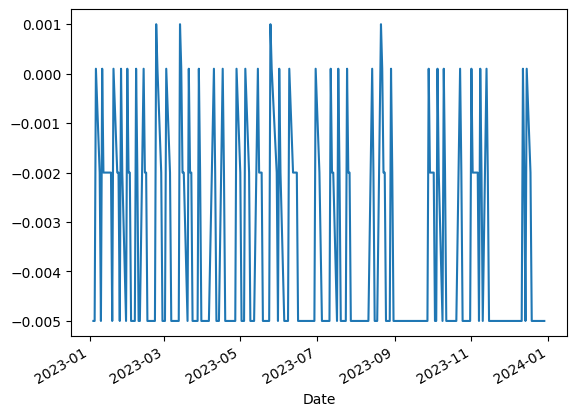

In [17]:
# print('Days in regime', analysis_results.days_in_regime)
# print('Expected duration of state', analysis_results.expected_duration)
# print('Expected return', analysis_results.expected_return)

analysis_results.expected_return.plot.line()

## Create Visualization

Generate a visualization showing the price chart with detected market regimes.

🎨 Creating visualization...


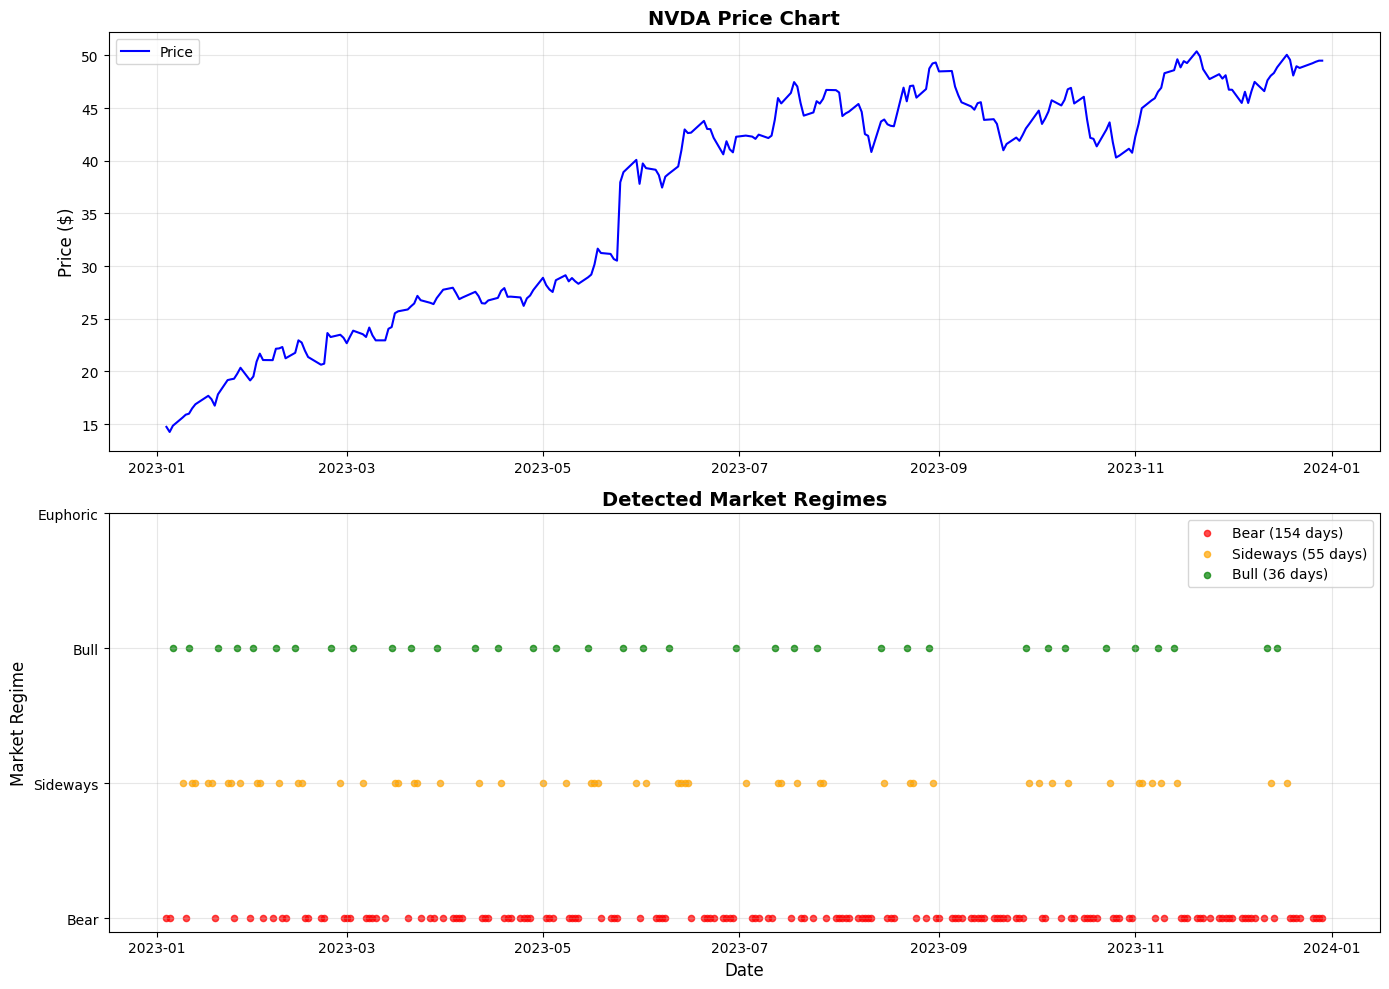

✅ Visualization saved as: ../../output/plots/notebook_regime_detection_NVDA_20250920_104220.png


In [21]:
if not raw_data.empty:
    print("🎨 Creating visualization...")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Price chart
    ax1.plot(raw_data.index, raw_data['close'], linewidth=1.5, color='blue', label='Price')
    ax1.set_title(f'{ticker} Price Chart', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Regime detection plot
    regime_colors = ['red', 'orange', 'green', 'blue']
    regime_names = ['Bear', 'Sideways', 'Bull', 'Euphoric']
    
    for i, regime in enumerate([0, 1, 2]):
        mask = model_output['predicted_state'] == regime
        if mask.sum() > 0:
            ax2.scatter(model_output.index[mask], [regime] * mask.sum(), 
                       c=regime_colors[i], alpha=0.7, s=20,
                       label=f'{regime_names[i]} ({mask.sum()} days)')
    
    ax2.set_title('Detected Market Regimes', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Market Regime', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yticks([0, 1, 2, 3])
    ax2.set_yticklabels(['Bear', 'Sideways', 'Bull', 'Euphoric'])
    
    plt.tight_layout()
    
    # Save plot to output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = os.path.join('..', '..', 'output', 'plots')
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f'notebook_regime_detection_{ticker}_{timestamp}.png')
    fig.savefig(plot_filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print(f"✅ Visualization saved as: {plot_filename}")
else:
    print("❌ Cannot create visualization without data")

## Generate Report

Create a comprehensive markdown report of the analysis results.

In [22]:
if not raw_data.empty:
    print("📝 Generating comprehensive report...")
    
    # Configure report generation
    report_config = ReportConfig(
        output_format="markdown",
        include_summary=True,
        include_regime_analysis=True,
        include_performance_metrics=True,
        save_plots=False,  # We already saved plots above
        show_plots=False
    )
    
    report_generator = MarkdownReportGenerator(report_config)
    
    # Generate full report
    full_report = report_generator.update(
        data=raw_data,
        observations=observations,
        model_output=model_output,
        analysis=analysis_results
    )
    
    # Save report to output directory
    output_dir = os.path.join('..', '..', 'output', 'reports')
    os.makedirs(output_dir, exist_ok=True)
    report_filename = os.path.join(output_dir, f"notebook_regime_report_{ticker}_{timestamp}.md")
    
    with open(report_filename, 'w') as f:
        f.write(full_report)
    
    print(f"✅ Report saved as: {report_filename}")
    
    # Display a preview of the report
    print(f"\n📄 Report Preview (first 1000 characters):")
    print("-" * 50)
    print(full_report[:1000] + "..." if len(full_report) > 1000 else full_report)
else:
    print("❌ Cannot generate report without data")

📝 Generating comprehensive report...
✅ Report saved as: ../../output/reports/notebook_regime_report_NVDA_20250920_104220.md

📄 Report Preview (first 1000 characters):
--------------------------------------------------
# Hidden Regime Analysis Report

**Generated**: 2025-09-20 10:42:27  
**Template Style**: professional

---

## Executive Summary
**Data Period**: 2023-01-04 to 2023-12-29
**Total Observations**: 249
**Current Regime**: Crisis
**Confidence**: 65.4%
**Days in Current Regime**: 8
**Expected Daily Return**: -0.500%
**Expected Volatility**: 4.000%

## Regime Analysis
### Regime Distribution
| Regime | Occurrences | Percentage |
|--------|-------------|------------|
| Crisis | 154 | 61.8% |
| Bear | 55 | 22.1% |
| Sideways | 36 | 14.5% |
| Bull | 4 | 1.6% |
### Regime Stability
- **Total Regime Changes**: 112
- **Average Regime Duration**: 2.2 periods
### Current Regime Details
- **Regime**: Crisis
- **Confidence**: 65.4%
- **Duration**: 8 periods
- **Expected Total Duration**

## Summary

This notebook demonstrated the complete workflow for regime detection using the hidden-regime package:

In [23]:
if not raw_data.empty:
    print("🎉 Regime Detection Analysis Complete!")
    print("=" * 50)
    
    print(f"\n📊 Summary for {ticker}:")
    print(f"   Data Period: {len(raw_data)} days")
    print(f"   Current Regime: {regime_names[current_regime]}")
    print(f"   Confidence: {confidence:.1%}")
    
    print(f"\n📁 Generated Files:")
    print(f"   • Report: {report_filename}")
    print(f"   • Visualization: {plot_filename}")
    
    print(f"\n✅ Capabilities Demonstrated:")
    print(f"   ✅ Real financial data loading")
    print(f"   ✅ Observation generation")
    print(f"   ✅ HMM model training")
    print(f"   ✅ Regime detection")
    print(f"   ✅ Financial analysis")
    print(f"   ✅ Report generation")
    print(f"   ✅ Visualization")
    
    print(f"\n🔬 Next Steps:")
    print(f"   • Try different tickers (SPY, MSFT, TSLA, etc.)")
    print(f"   • Experiment with different time periods")
    print(f"   • Explore advanced analysis features")
    print(f"   • Use regime detection for trading strategies")
else:
    print("❌ Analysis could not be completed due to data loading issues")
    print("   Please check your internet connection and try again")

🎉 Regime Detection Analysis Complete!

📊 Summary for NVDA:
   Data Period: 249 days
   Current Regime: Bear
   Confidence: 65.4%

📁 Generated Files:
   • Report: ../../output/reports/notebook_regime_report_NVDA_20250920_104220.md
   • Visualization: ../../output/plots/notebook_regime_detection_NVDA_20250920_104220.png

✅ Capabilities Demonstrated:
   ✅ Real financial data loading
   ✅ Observation generation
   ✅ HMM model training
   ✅ Regime detection
   ✅ Financial analysis
   ✅ Report generation
   ✅ Visualization

🔬 Next Steps:
   • Try different tickers (SPY, MSFT, TSLA, etc.)
   • Experiment with different time periods
   • Explore advanced analysis features
   • Use regime detection for trading strategies
